# Molecular design ML-in-the-loop workflow with Parsl

This notebook demonstrates a simple molecular design application where we use machine learning to guide which computations we perform.
The objective of this application is to identify which molecules have the largest ionization energies (IE, the amount of energy required to remove an electron). 

IE can be computed using various simulation packages (here we use [xTB](https://xtb-docs.readthedocs.io/en/latest/contents.html) ); however, execution of these simulations is expensive, and thus, given a finite compute budget, we must carefully select which molecules to explore. We use machine learning to predict high IE molecules based on previous computations (a process often called [active learning](https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.0c00768)). We iteratively retrain the machine learning model to improve the accuracy of predictions. The resulting ML-in-the-loop workflow proceeds as follows. 

![workflow](figures/workflow.svg)

In this notebook, we use Parsl to execute functions (simulation, model training, and inference) in parallel. Parsl allows us to establish dependencies in the workflow and to execute the workflow on arbitrary computing infrastructure, from laptops to supercomputers. We show how Parsl's integration with Python's native concurrency library (i.e., [`concurrent.futures`](https://docs.python.org/3/library/concurrent.futures.html#module-concurrent.futures)) let you write applications that dynamically respond to the completion of asynchronous tasks.

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
from chemfunctions import compute_vertical
from concurrent.futures import as_completed
from tqdm.notebook import tqdm
from parsl.executors import HighThroughputExecutor
from parsl.addresses import address_by_hostname
from parsl.providers import LocalProvider
from parsl.launchers import MpiExecLauncher
from parsl.app.python import PythonApp
from parsl.app.app import python_app
from parsl.config import Config
from time import monotonic
from random import sample
from pathlib import Path
import pandas as pd
import numpy as np
import parsl
import os
import sys

## Define problem

We first define configuration parameters for the app, specifically the search space of molecules (selected randomly from the QM9 database) and parameters controlling the optimization algorithm (the number of initial simulations, total moleucles to be evaluated, and the number of molecules to be evaluated in a batch).

In [2]:
# TODO: change path to data
search_space = pd.read_csv('/home/balin/AI4S/data/QM9-search.tsv', sep=r'\s+') # Our search space of molecules

In [3]:
initial_count: int = 16  # Number of calculations to run at first

In [4]:
search_count: int = 40   # Number of molecules to evaluate in total

In [5]:
batch_size: int = 8  # Number of molecules to evaluate in each batch of simulations

In [17]:
sys.path.append('/home/balin/AI4S/_ai4s_simAI/lib/python3.12/site-packages')
sys.path.append('/home/balin/AI4S/ai-science-training-series/03-Coupling-Sim-AI')
new_path_entry = "/home/balin/AI4S/_ai4s_simAI/bin"
os.environ['PATH'] = f"{new_path_entry}{os.pathsep}{os.environ['PATH']}"

## Set up Parsl

We now configure Parsl to make use of available resources. In this case, we configure Parsl to run on one Polaris compute node. This problem does not use GPUs, so we set one woker per CPU for a total of 64 workers.  For a GPU application, we would change the `Config` to pin one worker per GPU.  You can pin one worker per GPU by setting `available_accelerators=4` in the `HighThroughputExecutor`.

One of the benefits of Parsl is that we can change this configuration to make use of different resources without modifying the workflow. For example, we can configure Parsl to use more cores on the local machine or to use many nodes on a Supercomputer or Cloud. The [Parsl website](https://parsl.readthedocs.io/en/stable/userguide/configuring.html) describes how Parsl can be configured for different resources.

In [19]:
num_nodes = 1
run_dir=os.getcwd()

polaris_config = Config(
    executors=[
        HighThroughputExecutor(
            #available_accelerators=4,  # Set this for an application that uses GPUs to set one worker per GPU
            max_workers_per_node=32, # We will use 32 workers, one for each CPU
            cpu_affinity="alternating",  # Prevents thread contention
            prefetch_capacity=0,  # Increase if you have many more tasks than workers
            provider=LocalProvider(
                launcher=MpiExecLauncher(
                    bind_cmd="--cpu-bind", overrides="--ppn 1"
                ),  # Ensures 1 manger per node and allows it to divide work to all 32 cores
                #select_options="ngpus=4", # This option should be set if using GPUs
                worker_init="module use /soft/modulefiles/; module load conda/2025-09-25; conda activate /home/balin/AI4S/_ai4s_simAI; cd "+run_dir",
                nodes_per_block=num_nodes,
                init_blocks=1,
                max_blocks=1,
            ),
        ),
    ]
)

parsl.load(polaris_config)

## Make an initial dataset

We need data to train our ML models. We'll do that by selecting a set of molecules at random from our search space, performing some simulations on those molecules, and training on the results.

In [`chemfunctions.py`](./chemfunctions.py), we have defined a function `compute_vertical` that computes the "vertical ionization energy" of a molecule (a measure of how much energy it takes to strip an electron off the molecule). `compute_vertical` takes a string representation of a molecule in [SMILES format](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) as input and returns the ionization energy as a float. Under the hood, it is running [xTB](https://xtb-docs.readthedocs.io/en/latest/contents.html) to perform a series of quantum chemistry computations.

### Execute a first simulation
We need to prepare this function to run with Parsl. All we need to do is wrap this function with Parsl's `python_app`:

In [10]:
compute_vertical_app = python_app(compute_vertical)
compute_vertical_app

This new object is a Parsl `PythonApp`. It can be invoked like the original function, but instead of immediately executing, the function may be run asynchronously by Parsl. Instead of the result, the call will immediately return a `Future` which we can use to retrieve the result or obtain the status of the running task.

For example, invoking the `compute_verticle_app` with the SMILES for water, `O`, returns a Future and schedules `compute_verticle` for execution in the background.

In [20]:
future = compute_vertical_app('O') #  Run water as a demonstration (O is the SMILES for water)
future

<AppFuture at 0x1465b09d3c20 state=pending>

We can access the result of this computation by asking the future for the `result()`. If the computation isn't finished yet, then the call to `.result()` will block until the result is ready.

In [21]:
ie = future.result()
print(f"The ionization energy of {future.task_record['args'][0]} is {ie:.2f} eV")

ModuleNotFoundError: No module named 'chemfunctions'

### Scale the simulation

It is trivial now to scale our simulation and run it for several different molecules and gather their results.

We use a standard Python loop to submit a set of simulations for execution. As above, each invocation returns a `Future` immediately, so this code should finish within a few milliseconds.

Because we never call `.result()`, this code does not wait for any results to be ready. Instead, Parsl is running the computations in the background. Parsl manages sending work to each worker process, collecting results, and feeding new work to workers as new tasks are submitted.

In [11]:
%%time
smiles = search_space.sample(initial_count)['smiles']
futures = [compute_vertical_app(s) for s in smiles]
print(f'Submitted {len(futures)} calculations to start with')

Submitted 16 calculations to start with
CPU times: user 13.4 ms, sys: 14.2 ms, total: 27.6 ms
Wall time: 23.3 ms


The futures produced by Parsl are based on Python's [native "Future"](https://docs.python.org/3/library/concurrent.futures.html#future-objects) object,
so we can use Python's utility functions to work with them.

As an example, we can build a loop that submits new computations if previous ones fail. This happens not too infrequently with our simulation application.

We use `as_completed` to take an iterable (in this case a list) of futures and to yeild as each future completes.  Thus, we progress and handle each simulation as it completes

We also use, `Future.exception()` rather than the similar `Future.result()`. `Future.exception()` behaves similarly in that it will block until the relevant task is completed, but rather than return the result, it returns any exception that was raised during execution (or `None` if not). In this case, if the future returns an exception we simply pick a new molecule and re-execute the simulation.

In [12]:
train_data = []
while len(futures) > 0: 
    # First, get the next completed computation from the list
    future = next(as_completed(futures))
    
    # Remove it from the list of still-running tasks
    futures.remove(future)
    
    # Get the input 
    smiles = future.task_record['args'][0]
    
    # Check if the run completed successfully
    if future.exception() is not None:
        # If it failed, pick a new SMILES string at random and submit it    
        print(f'Computation for {smiles} failed, submitting a replacement computation')
        smiles = search_space.sample(1).iloc[0]['smiles'] # pick one molecule
        new_future = compute_vertical_app(smiles) # launch a simulation in Parsl
        futures.append(new_future) # store the Future so we can keep track of it
    else:
        # If it succeeded, store the result
        print(f'Computation for {smiles} succeeded')
        train_data.append({
            'smiles': smiles,
            'ie': future.result(),
            'batch': 0,
            'time': monotonic()
        })

Computation for N#CC1=NNN=C1C#N succeeded
Computation for CCCC1=NC=NC=N1 succeeded
Computation for O=C1C2OC2CC11CO1 succeeded
Computation for N#CC1NCC=C1C#N succeeded
Computation for CCOCC(C)C1CC1 succeeded
Computation for CCN1CC1(C#C)C#N succeeded
Computation for COC1OCCCC1=O succeeded
Computation for CC#CC(C)(C)C1CO1 succeeded
Computation for CN1CCC=C(C)C1=O succeeded
Computation for O=CNC1CC(=O)C=C1 succeeded
Computation for NC1=C2C(O)CN2C=N1 succeeded
Computation for CCC1(OC1C#N)C#N succeeded
Computation for CN1C(CO)C1C(N)=O succeeded
Computation for CC1=C(C)C(O)CCC1 succeeded
Computation for N#CC1COCC1C#N succeeded
Computation for NCC(O)(CC#N)C#N succeeded


We now have an initial set of training data. We load this training data into a pandas `DataFrame` containing the randomly samples molecules alongside the simulated ionization energy (`ie`). In addition, the code above has stored some metadata (`batch` and `time`) which we will use later.

In [13]:
train_data = pd.DataFrame(train_data)
train_data

,smiles,ie,batch,time
0,N#CC1=NNN=C1C#N,15.245789,0,5.241523e+06
1,CCCC1=NC=NC=N1,13.518389,0,5.241523e+06
2,O=C1C2OC2CC11CO1,14.232959,0,5.241523e+06
3,N#CC1NCC=C1C#N,13.908206,0,5.241523e+06
4,CCOCC(C)C1CC1,13.239983,0,5.241523e+06
5,CCN1CC1(C#C)C#N,13.622593,0,5.241523e+06
6,COC1OCCCC1=O,13.636462,0,5.241523e+06
7,CC#CC(C)(C)C1CO1,13.396942,0,5.241523e+06
8,CN1CCC=C(C)C1=O,13.083425,0,5.241523e+06
9,O=CNC1CC(=O)C=C1,13.875744,0,5.241523e+06


## Train a machine learning model to screen candidate molecules
Our next step is to create a machine learning model to estimate the outcome of new computations (i.e., ionization energy) and use it to rapidly scan the search space.

To start, let's make a function that uses our prior simulations to train a model. We are going to use RDKit and scikit-learn to train a nearest-neighbor model that uses Morgan fingerprints to define similarity (see [notes from a UChicago AI course](https://github.com/WardLT/applied-ai-for-materials/blob/main/molecular-property-prediction/chemoinformatics/2_ml-with-fingerprints.ipynb) for more detail). In short, the function trains a model that first populates a list of certain substructures (Morgan fingerprints, specifically) and then trains a model which predicts the IE of a new molecule by averaging those with the most similar substructures.

We want to use Parsl here to scale the model and to later combine it into our ML-in-the-loop workflow. To do so, we define the function using `python_app`. This time, `python_app` is used as a decorator directly on the function definition (earlier we defined a regular function, and then applied `python_app` afterwards).

In [14]:
@python_app
def train_model(train_data):
    """Train a machine learning model using Morgan Fingerprints.
    
    Args:
        train_data: Dataframe with a 'smiles' and 'ie' column
            that contains molecule structure and property, respectfully.
    Returns:
        A trained model
    """
    # Imports for python functions run remotely must be defined inside the function
    from chemfunctions import MorganFingerprintTransformer
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.pipeline import Pipeline
    
    
    model = Pipeline([
        ('fingerprint', MorganFingerprintTransformer()),
        ('knn', KNeighborsRegressor(n_neighbors=4, weights='distance', metric='jaccard', n_jobs=-1))  # n_jobs = -1 lets the model run all available processors
    ])
    
    return model.fit(train_data['smiles'], train_data['ie'])

Now let's execute the function and run it asynchronously with Parsl

In [15]:
train_future = train_model(train_data)

One of the unique features of Parsl is that it can create workflows on-the-fly directly from Python. Parsl workflows are chains of functions, connected by dynamic depencies (i.e., data passed between Parsl `apps`), that can run in parallel when possible.

To establish the workflow, we pass the future created by executing one function an input to another Parsl function.

As an example, let's create a function that uses the trained model to run inference on a large set of molecules and then another that takes many predictions and concatenates them into a single collection. The sequential workflow is implemented as follows.

        train_model --> run_model --> combine_inferences

In [16]:
@python_app
def run_model(model, smiles):
    """Run a model on a list of smiles strings
    
    Args:
        model: Trained model that takes SMILES strings as inputs
        smiles: List of molecules to evaluate
    Returns:
        A dataframe with the molecules and their predicted outputs
    """
    import pandas as pd
    pred_y = model.predict(smiles)
    return pd.DataFrame({'smiles': smiles, 'ie': pred_y})

In [17]:
@python_app
def combine_inferences(inputs=[]):
    """Concatenate a series of inferences into a single DataFrame
    Args:
        inputs: a list of the component DataFrames
    Returns:
        A single DataFrame containing the same inferences
    """
    import pandas as pd
    return pd.concat(inputs, ignore_index=True)

Now we've created our Parsl `apps`, we can chop up the search space into chunks, and invoke `run_model`  once for each chunk of the search space.

Note: we pass `train_future` (the future created from the training function above) as input to `run_model`. Parsl will wait for the training to be complete (i.e., the future to be resolved) before executing `run_model`.

In [18]:
# Chunk the search space into smaller pieces, so that each can run in parallel
chunks = np.array_split(search_space['smiles'], 64)
inference_futures = [run_model(train_future, chunk) for chunk in chunks]

While we are running inferences in parallel we can define the final part of the workflow to combine results into a single DataFrame using `combine_inferences`.

We pass the `inference_futures` as inputs to `combine_inferences` such that Parsl knows to establish a dependency between these two functions. That is, Parsl will ensure that `train_future` must complete before any of the `run_model` tasks start; and all of the `run_model` tasks must be finished before `combine_inferences` starts.

In [19]:
# We pass the inputs explicitly as a named argument "inputs" for Parsl to recognize this as a "reduce" step
#  See: https://parsl.readthedocs.io/en/stable/userguide/workflow.html#mapreduce
predictions = combine_inferences(inputs=inference_futures).result()

#### Results

After completing the inference process we now have predicted IE values for all molecules in our search space. We can print out the best five molecules, according to the trained model:

In [20]:
predictions.sort_values('ie', ascending=False).head(5)

,smiles,ie
125817,N#CC1=NNN=C1C#N,15.245789
102643,CCC1(OC1C#N)C#N,14.892121
84838,CC1CC(C1)NCC#N,14.781804
63790,OC1(CCC#N)COC1,14.779342
2954,N#CCNC1CC1,14.779102


We have now created a Parsl workflow that is able to train a model and use it to identify molecules that are likely to be good next choices for simulations. Time to build a model-in-the-loop workflow.

## Model-in-the-Loop Workflow
We are going to build an application that uses a machine learning model to pick a batch of simulations, runs the simulations in parallel, and then uses the data to retrain the model before repeating the loop.

Our application uses `train_model`, `run_model`, and `combine_inferences` as above, but after running an iteration it picks the predicted best molecules and runs the `compute_vertical_app` to run the xTB simulation.  The workflow then repeatedly retrains the model using these results until a fixed number of molecule simulations have been trained. 

Make the search space a list so that we can remove completed molecules more easily

In [21]:
# Mark when we started
start_time = monotonic()

# Start with some random guesses for simulations
train_data = []
init_mols = search_space.sample(initial_count)['smiles']
sim_futures = [compute_vertical_app(mol) for mol in init_mols]
already_ran = set()

# Loop until you finish populating the initial set of simulation results
while len(sim_futures) > 0: 
    # First, get the next completed computation from the list
    future = next(as_completed(sim_futures))

    # Remove it from the list of still-running tasks
    sim_futures.remove(future)

    # Get the input 
    smiles = future.task_record['args'][0]
    already_ran.add(smiles)

    # Check if the run completed successfully
    if future.exception() is not None:
        # If it failed, pick a new SMILES string at random and submit it    
        smiles = search_space.sample(1).iloc[0]['smiles'] # pick one molecule
        new_future = compute_vertical_app(smiles) # launch a simulation in Parsl
        sim_futures.append(new_future) # store the Future so we can keep track of it
    else:
        # If it succeeded, store the result
        train_data.append({
            'smiles': smiles,
            'ie': future.result(),
            'batch': 0,
            'time': monotonic() - start_time
        })

# Create the initial training set as a 
train_data = pd.DataFrame(train_data)

# Loop until complete
batch = 1
while len(train_data) < search_count:
    start_loop_time = monotonic()
    print(f"Batch {batch} training on {len(train_data)} simulation results")
    # Train and predict as shown in the previous section.
    train_future = train_model(train_data)
    chunks = np.array_split(search_space['smiles'], 32)

    inference_futures = [run_model(train_future, chunk) for chunk in chunks]
    predictions = combine_inferences(inputs=inference_futures).result()

    print("Finished training and inference")
    # Sort the predictions in descending order, and submit new molecules from them
    predictions.sort_values('ie', ascending=False, inplace=True)
    sim_futures = []
    for smiles in predictions['smiles']:
        if smiles not in already_ran:
            sim_futures.append(compute_vertical_app(smiles))
            already_ran.add(smiles)
            if len(sim_futures) >= batch_size:
                break
    print(f"Finished Sorting {len(sim_futures)=}")
    # Wait for every task in the current batch to complete, and store successful results
    new_results = []
    for future in as_completed(sim_futures):
        if future.exception() is None:
            new_results.append({
                'smiles': future.task_record['args'][0],
                'ie': future.result(),
                'batch': batch, 
                'time': monotonic() - start_time
            })
    print("Finished Simulations")     
    # Update the training data and repeat
    batch += 1
    train_data = pd.concat((train_data, pd.DataFrame(new_results)), ignore_index=True)
    print(f"...finished loop iter in {monotonic() - start_loop_time}s")

Batch 1 training on 16 simulation results
Finished training and inference
Finished Sorting len(sim_futures)=8
Finished Simulations
...finished loop iter in 14.047948858700693s
Batch 2 training on 24 simulation results
Finished training and inference
Finished Sorting len(sim_futures)=8
Finished Simulations
...finished loop iter in 14.369727892801166s
Batch 3 training on 32 simulation results
Finished training and inference
Finished Sorting len(sim_futures)=8
Finished Simulations
...finished loop iter in 14.075956555083394s


We can plot the training data against the time of simulation, showing that the model is finding better molecules over time. 

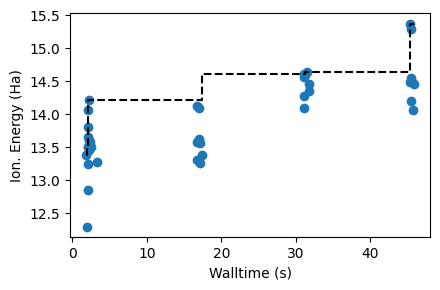

In [22]:
fig, ax = plt.subplots(figsize=(4.5, 3.))

ax.scatter(train_data['time'], train_data['ie'])
ax.step(np.array(train_data['time']), np.array(train_data['ie'].cummax()), 'k--')
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Ion. Energy (Ha)')

fig.tight_layout()

Save that data for comparison with another application later

In [23]:
Path('run-data').mkdir(exist_ok=True)
train_data.to_csv('run-data/parsl-results.csv', index=False)